# Housing price one-shot forecasting using a multivariate LSTM model

We want to predict housing prices in the future using the time series data currently available to us. Initially, we attempted to use a simple ARIMA model to forecast future prices, but we realized that such a basic model would not be sufficient for predicting values in an uncertain market like the housing market. Now, we are planning to implement a multivariate Long Short-Term Memory (LSTM) model for future forecasting. The LSTM network is a type of recurrent neural network (RNN) that can be employed to predict values based on time series data. One-shot forecasting means making a prediction for the following month and comparing it to the actual outcome before making the next prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.metrics import mean_squared_error

## 1. Data preperation

In addition to monthly average housing prices that we scraped, we also have the monthly number of housing advertisements on <a href="https://www.kv.ee/">kv.ee</a>, housing loan interest rates over the years, and the average salary over the years.

Firstly, we are going to read and refactor all the data from different sources and merge them into a single time series dataframe.

In [2]:
def readData(district="Tallinn"):
    # 1. Read and prepare housing data
    data = pd.read_csv("../data/lstm/housingData.csv",encoding='latin-1')
    data.date = data.date.astype("str")
    data["date"] = pd.to_datetime(data["date"], format='%m-%Y')
    data = data.replace('-', np.nan)
    data = data.ffill() #Forward Fill 
    data.price = data.price.astype("float")
    data.advertisements = data.advertisements.astype("int")
    data = data.drop(["actives", "city"], axis=1)
    data = data[data.district == district]
    
    # 2. Read and prepare housing loan interest rate data
    dataInterestRate = pd.read_csv("../data/lstm/interestRateData.csv", delimiter=';',  encoding="latin-1")
    dataInterestRate = dataInterestRate.drop(dataInterestRate.columns[0], axis=1)
    dataInterestRate = dataInterestRate.drop(',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,', axis=1)
    dataInterestRate = dataInterestRate.loc[[4]]
    df_melted = pd.melt(dataInterestRate, var_name='date', value_name='interest_rate', ignore_index=False)
    df_melted['interest_rate'] = df_melted['interest_rate'].str.replace(',', '.').str.replace('%', '').astype(float)
    df_melted.reset_index(inplace=True)
    dataInterestRate = dataInterestRate.drop(dataInterestRate.columns[0], axis=1)
    df_melted["date"] = pd.to_datetime(df_melted["date"], format='%m.%Y')
    df_melted = df_melted.drop("index", axis=1)
    
    # 3. Read and prepare income data from first file
    incomeData1 = pd.read_csv("../data/lstm/kuupalk2007-2018.csv", skiprows=2,encoding='latin-1')
    incomeData1['Maakond'] = incomeData1['Maakond'].replace({'..Tallinn': 'Tallinn', 'Tartu maakond': 'Tartu'})
    incomeData1.rename(columns={'Keskmine brutokuupalk, eurot': 'salary'}, inplace=True)
    incomeData1.rename(columns={'Maakond': 'district'}, inplace=True)
    incomeData1.rename(columns={'Aasta': 'year'}, inplace=True)
    incomeData1.rename(columns={'Keskmise brutokuupalga juurdekasvutempo vÃµrreldes eelmise perioodiga, %': 'difference'}, inplace=True)
    incomeData1 = incomeData1[incomeData1.district == district]
    #incomeData1['difference'] = incomeData1['difference'].astype(float)

    kvartal_mapping = {'I kvartal': 1, 'II kvartal': 2, 'III kvartal': 3, 'IV kvartal': 4}
    incomeData1['Kvartal'] = incomeData1['Kvartal'].map(kvartal_mapping)
    incomeData1['year'] = incomeData1['year'].astype(int)

    # Create a new DataFrame with 12 months for each year
    expanded_dates = pd.DataFrame({
        'year': np.repeat(incomeData1['year'].unique(), 12),
        'month': np.tile(np.arange(1, 13), len(incomeData1['year'].unique()))
    })

    # Map each month to its corresponding quarter
    month_to_quarter = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 4, 11: 4, 12: 4}
    expanded_dates['Kvartal'] = expanded_dates['month'].map(month_to_quarter)

    # Merge the expanded_dates DataFrame with the original DataFrame
    result_df = pd.merge(expanded_dates, incomeData1, on=['year', 'Kvartal'], how='left')

    # Forward fill the values for 'district', 'salary', and 'difference'
    result_df[['district', 'salary', 'difference']] = result_df[['district', 'salary', 'difference']].ffill()
    result_df['date'] = pd.to_datetime(result_df[['year', 'month']].assign(day=1))
    result_df = result_df.drop(["Kvartal", "year", "month"], axis=1)
    result_df["date"] = pd.to_datetime(result_df["date"], format='%Y-%M')

    # 4. Read and prepare income data from second file
    incomeData2 = pd.read_csv("../data/lstm/kuupalk2018-2022.csv", skiprows=2,encoding='latin-1')
    incomeData2 = incomeData2.drop(index=range(4)) # Starts from 2018, already have these values
    incomeData2['Maakond'] = incomeData2['Maakond'].replace({'Tartu maakond': 'Tartu'})
    incomeData2.rename(columns={'Maakond': 'district','Keskmise brutokuupalga muutus vÃµrreldes eelmise perioodiga, %': 'difference', "Keskmine brutokuupalk, eurot":"salary"}, inplace=True)
    incomeData2.rename(columns={'Maakond': 'district'}, inplace=True)
    incomeData2['difference'] = incomeData2['difference'].replace("..", 6.6)
    incomeData2[['year', 'quartile']] = incomeData2['Vaatlusperiood'].str.split(' ', n=1, expand=True)
    quartile_to_int = {'I kvartal': 1, 'II kvartal': 2, 'III kvartal': 3, 'IV kvartal': 4}
    incomeData2['quartile'] = incomeData2['quartile'].map(quartile_to_int)
    incomeData2['year'] = incomeData2['year'].astype(int)
    incomeData2 = incomeData2.drop("Vaatlusperiood", axis=1)
    incomeData2['difference'] = incomeData2['difference'].astype(float)
    incomeData2 = incomeData2[incomeData2['district'] == district]

    # Create a new DataFrame with 12 months for each year
    expanded_dates = pd.DataFrame({
        'year': np.repeat(incomeData2['year'].unique(), 12),
        'month': np.tile(np.arange(1, 13), len(incomeData2['year'].unique()))
    })

    expanded_dates['quartile'] = expanded_dates['month'].map(month_to_quarter)

    # Merge the expanded_dates DataFrame with the original DataFrame
    result_df2 = pd.merge(expanded_dates, incomeData2, on=['year', 'quartile'], how='left')

    # Forward fill the values for 'district', 'salary', and 'difference'
    result_df2[['district', 'salary', 'difference']] = result_df2[['district', 'salary', 'difference']].ffill()
    result_df2['date'] = pd.to_datetime(result_df2[['year', 'month']].assign(day=1))
    result_df2 = result_df2.drop(["year", "month", "quartile"], axis=1)
    result_df2["date"] = pd.to_datetime(result_df2["date"], format='%Y-%M')

    # Merge both salary dataframes together
    data_salary = pd.merge(result_df, result_df2, on=None, how='outer')
    data_salary = data_salary.sort_values('date')  # Sort the merged DataFrame by the 'date' column
    data_salary = data_salary.drop(["district"], axis=1)
    
    # 5. Merge the datasets
    df_merged = pd.merge(data, df_melted, on='date', how='left')
    df_merged = pd.merge(df_merged, data_salary, on='date', how='left')
    
    return df_merged

In [3]:
data = readData("Tallinn")
data = data.dropna(subset=["salary"]) # Since one time series dataset ended a year earlier, we have to remove those values
data.head()

,date,district,price,advertisements,interest_rate,salary,difference
0,2007-05-01,Tallinn,1993.2,7252,5.63,840.0,8.0
1,2007-06-01,Tallinn,1948.8,7405,5.65,840.0,8.0
2,2007-07-01,Tallinn,1935.0,7644,5.87,799.0,-4.9
3,2007-08-01,Tallinn,1922.1,7945,5.98,799.0,-4.9
4,2007-09-01,Tallinn,1912.4,8476,6.09,799.0,-4.9


## 2. Refactoring data and feature scaling

Next, we are going to refactor the data to a shape that the LSTM needs for input. Firstly, we are normalizing the dataset using min-max scaling. We are doing so because neural networks, including LSTMs, often converge faster when the input features are on a similar scale. Then, we are going to split the data into a training and test set. Each row will have the price as a label, and the values of the previous 60 rows (5 years) will serve as features.

In [4]:
# Normalize the dataset
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_advertisements = MinMaxScaler(feature_range=(0, 1))
scaler_interest_rate = MinMaxScaler(feature_range=(0, 1))

scaled_price = scaler_price.fit_transform(data[['price']])
scaled_advertisements = scaler_advertisements.fit_transform(data[['advertisements']])
scaled_interest_rate = scaler_interest_rate.fit_transform(data[['interest_rate']])

scaled_data = np.concatenate((scaled_price, scaled_advertisements, scaled_interest_rate, data[['difference']]), axis=1)

In [5]:
# Split the data into training set and test set
train_length = int(len(scaled_data) * 0.8)
val_length = int(len(scaled_data) * 0.1)

train_data = scaled_data[0:train_length,:]
val_data = scaled_data[train_length-60:train_length+val_length,:]
test_data = scaled_data[train_length+val_length-60:,:]


# 1. Create the training data set
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,:]) # For every row take the values for past 60 rows
    y_train.append(train_data[i,0]) # Actual price 
    
# Convert the x_train and y_train to numpy arrays and reshaping
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 4))



# 2. Create the validation data set
x_val = []
y_val = data.iloc[train_length:train_length+val_length, :]['price']

for i in range(60, len(val_data)):
    x_val.append(val_data[i-60:i, :])

# Convert the data to a numpy array
x_val = np.array(x_val)



# 3. Create the testing data set
x_test = []
y_test = data.iloc[train_length+val_length:, :]['price']

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

# Convert the data to a numpy array
x_test = np.array(x_test)


## 3. Defining model arcitecture

We are going to specify the model architecture that will be used going forward. The architecture includes an LSTM layer, followed by densely connected layers. The model is trained using mean squared error (mse) loss and the Adam optimizer. All other values, such as the node count on each layer and data used for model fitting, can be passed into the function as parameters.

In [6]:
def create_lstm_model(x_train, y_train, config): 
    layer1_nodes,layer2_nodes,layer3_nodes, n_batch, n_epochs = config
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1], 4)))
    model.add(LSTM(layer1_nodes, activation='relu', return_sequences=False))
    model.add(Dense(layer2_nodes))
    model.add(Dense(layer3_nodes))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

## 4. Using grid search to find the best hyperparameters

To determine the optimal hyperparameters for our model, we opted to employ grid search. Initially, our intention was to use <code>GridSearchCV</code> from the scikit-learn library. However, after encountering numerous errors using scikeras wrappers for the Tensorflow model and finding limited helpful information online, we decided to resort to manual implementation.

**The function callout for grid search is commented out** since its execution time is prolonged. The first grid search we conducted lasted for 18 hours.

In [14]:
def model_configs(): # Define the hyperparameter grid
 layer1_nodes = [50, 75, 100]
 layer2_nodes = [25, 50, 75, 100]
 layer3_nodes = [25, 50, 75]
 n_batch = [32, 64, 128]
 n_epochs = [400, 700, 1000, 1400]
 
 configs = list()
 for i in layer1_nodes:
    for j in layer2_nodes:
         for k in layer3_nodes:
            for m in n_batch:
                for o in n_epochs:
                    configs.append([i, j, k, m, o])
 print('Total configs: %d' % len(configs))
 return configs

In [8]:
def evaluate(x_train, y_train, x_val, y_val, config):
    model = create_lstm_model(x_train, y_train, config)
    predictions = model.predict(x_val)
    predictions = scaler_price.inverse_transform(predictions) # Undo scaling
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [9]:
def repeat_evaluate(x_train, y_train, x_val, y_val, config, n_repeats=15):
    evaluation_scores = []
    
    # fit and evaluate the model n times
    for _ in range(n_repeats):
        validation_score = evaluate(x_train, y_train, x_val, y_val, config)
        evaluation_scores.append(validation_score)
        
    key = str(config)
    print("Evaluation scores: ", evaluation_scores)
    result = mean(evaluation_scores)
    print('> Model[%s] received RMSE %.3f' % (key, result))
    return result

In [10]:
def grid_search(x_train, y_train, x_val, y_val, configurations):
    
    # Evaluate configurations and store results in a list
    evaluated_configs = []
    for config in configurations:
        evaluation_result = repeat_evaluate(x_train, y_train, x_val, y_val, config, 20)
        evaluated_configs.append((config, evaluation_result)) # store the configuration and repeated evaluation score as a pair 

    # Sort configurations by error in ascending order
    sorted_configs = sorted(evaluated_configs, key=lambda x: x[1])
    return sorted_configs

In [15]:
configs = model_configs()
scores = []

#%time scores = grid_search(x_train, y_train,x_val, y_val, configs)

# Find the three configurations with the best error values
for configuration, error in scores[:3]:
 print(configuration, error)


Total configs: 432


## 5. Building the final model and making predictions

We are going to fit the final LSTM model with hyperparameters we found using grid search in the previous step. For fitting we are going to use all the available training + validation data. After the model has been trained, we will predict values for the testing data and calculate the RMSE.

In [12]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 4)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(75))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=1000)

# Get the models predicted price values.
# We are combining and predicting values for both the validation and test datasets for better visualization on the plot

# Concatenate x_val and x_test
x_combined = np.concatenate((x_val, x_test), axis=0)
predictions = model.predict(x_combined)
predictions = scaler_price.inverse_transform(predictions) # Undo scaling

# Calculate RMSE
y_combined = np.concatenate((y_val, y_test), axis=0)
rmse = np.sqrt(mean_squared_error(y_combined, predictions))
print('Root Mean Square Error:', rmse, " €")


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2598
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0914
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0256
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0352
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0676
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0781
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0648
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0426
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0239
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0145
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0145
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0201
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0266
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0305
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0301
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.7281e-04
Epoch 82/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.8301e-04
Epoch 83/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.8185e-04
Epoch 84/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.6492e-04
Epoch 85/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.4590e-04
Epoch 86/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.3820e-04
Epoch 87/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 4.3984e-04
Epoch 88/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.3827e-04
Epoch 89/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.2652e-04
Epoch 90/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.1033e-04
Epoch 91/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.9948e-04
Epoch 92/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.9598e-04
Epoch 93/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.9321e-04
Epoch 94/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.8521e-04
Epoch 95/1000
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 2.1459e-04
Epoch 159/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.1333e-04
Epoch 160/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.1210e-04
Epoch 161/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.1088e-04
Epoch 162/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.0968e-04
Epoch 163/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.0848e-04
Epoch 164/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.0730e-04
Epoch 165/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.0614e-04
Epoch 166/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0500e-04
Epoch 167/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.0386e-04
Epoch 168/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.0274e-04
Epoch 169/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.0163e-04
Epoch 170/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.0054e-04
Epoch 171/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.9946e-04
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4970e-04
Epoch 236/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.4914e-04
Epoch 237/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.4857e-04
Epoch 238/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.4801e-04
Epoch 239/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4745e-04
Epoch 240/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.4690e-04
Epoch 241/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4635e-04
Epoch 242/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.4580e-04
Epoch 243/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.4526e-04
Epoch 244/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.4472e-04
Epoch 245/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.4419e-04
Epoch 246/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4366e-04
Epoch 247/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.4313e-04
Epoch 248/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.4261e-04
Epoch 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.1455e-04
Epoch 313/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1417e-04
Epoch 314/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.1380e-04
Epoch 315/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.1343e-04
Epoch 316/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.1306e-04
Epoch 317/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1269e-04
Epoch 318/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.1233e-04
Epoch 319/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.1196e-04
Epoch 320/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1160e-04
Epoch 321/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.1124e-04
Epoch 322/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.1088e-04
Epoch 323/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.1052e-04
Epoch 324/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.1016e-04
Epoch 325/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.0981e-04
Epoch 3

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.9702e-05
Epoch 390/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.9425e-05
Epoch 391/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.9148e-05
Epoch 392/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.8873e-05
Epoch 393/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.8599e-05
Epoch 394/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 8.8326e-05
Epoch 395/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.8054e-05
Epoch 396/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.7783e-05
Epoch 397/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 8.7513e-05
Epoch 398/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.7244e-05
Epoch 399/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 8.6976e-05
Epoch 400/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 8.6709e-05
Epoch 401/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 8.6443e-05
Epoch 402/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.6177e-05
Epoch 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.1111e-05
Epoch 467/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.0903e-05
Epoch 468/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.0696e-05
Epoch 469/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 7.0489e-05
Epoch 470/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 7.0284e-05
Epoch 471/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.0079e-05
Epoch 472/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.9875e-05
Epoch 473/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.9671e-05
Epoch 474/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6.9469e-05
Epoch 475/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.9267e-05
Epoch 476/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 6.9067e-05
Epoch 477/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 6.8866e-05
Epoch 478/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.8667e-05
Epoch 479/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 6.8469e-05
Epoch 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5.7231e-05
Epoch 544/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 5.7077e-05
Epoch 545/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 5.6924e-05
Epoch 546/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 5.6771e-05
Epoch 547/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 5.6618e-05
Epoch 548/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.6467e-05
Epoch 549/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.6316e-05
Epoch 550/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 5.6165e-05
Epoch 551/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.6015e-05
Epoch 552/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.5866e-05
Epoch 553/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.5717e-05
Epoch 554/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 5.5569e-05
Epoch 555/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 5.5422e-05
Epoch 556/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.5275e-05
Epoch 5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.7025e-05
Epoch 621/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.6913e-05
Epoch 622/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.6801e-05
Epoch 623/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.6690e-05
Epoch 624/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.6579e-05
Epoch 625/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.6469e-05
Epoch 626/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 4.6359e-05
Epoch 627/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 4.6249e-05
Epoch 628/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.6140e-05
Epoch 629/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.6032e-05
Epoch 630/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.5924e-05
Epoch 631/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.5816e-05
Epoch 632/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.5709e-05
Epoch 633/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 4.5602e-05
Epoch 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.9646e-05
Epoch 698/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.9565e-05
Epoch 699/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.9485e-05
Epoch 700/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.9405e-05
Epoch 701/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.9325e-05
Epoch 702/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.9246e-05
Epoch 703/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.9167e-05
Epoch 704/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.9089e-05
Epoch 705/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.9011e-05
Epoch 706/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8933e-05
Epoch 707/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.8855e-05
Epoch 708/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8778e-05
Epoch 709/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.8701e-05
Epoch 710/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.8625e-05
Epoch 7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.4366e-05
Epoch 775/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.4309e-05
Epoch 776/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.4252e-05
Epoch 777/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3.4194e-05
Epoch 778/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.4138e-05
Epoch 779/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.4081e-05
Epoch 780/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.4025e-05
Epoch 781/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.3969e-05
Epoch 782/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 3.3913e-05
Epoch 783/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.3857e-05
Epoch 784/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.3802e-05
Epoch 785/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.3747e-05
Epoch 786/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.3692e-05
Epoch 787/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.3637e-05
Epoch 7

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 3.0583e-05
Epoch 852/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.0541e-05
Epoch 853/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.0500e-05
Epoch 854/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 3.0459e-05
Epoch 855/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.0418e-05
Epoch 856/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.0377e-05
Epoch 857/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 3.0336e-05
Epoch 858/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.0296e-05
Epoch 859/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.0255e-05
Epoch 860/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 3.0215e-05
Epoch 861/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.0175e-05
Epoch 862/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.0135e-05
Epoch 863/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.0095e-05
Epoch 864/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.0056e-05
Epoch 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.7822e-05
Epoch 929/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7791e-05
Epoch 930/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.7760e-05
Epoch 931/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.7730e-05
Epoch 932/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 2.7699e-05
Epoch 933/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7669e-05
Epoch 934/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.7639e-05
Epoch 935/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7609e-05
Epoch 936/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.7579e-05
Epoch 937/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.7549e-05
Epoch 938/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.7519e-05
Epoch 939/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.7489e-05
Epoch 940/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.7460e-05
Epoch 941/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.7430e-05
Epoch 9

## 6. Plotting the results

Lastly, we are plotting the one-shot forecasting predictions of the model together with the actual values to gain a visual understanding of how well the model is performing. To scale the plot appropriately and display predictions on a larger scale, we are only plotting the training data starting from the year 2013.

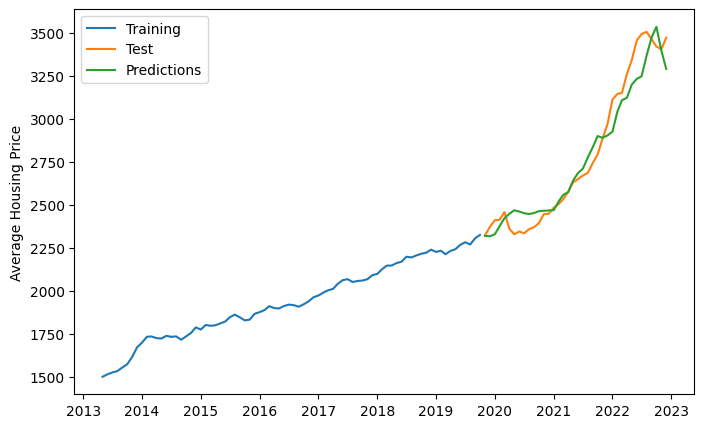

In [13]:
train = data[72:train_length]
test = data[train_length:].copy()
test.loc[72:, 'Predictions'] = predictions
plt.figure(figsize=(8,5))
plt.ylabel('Average Housing Price')
plt.plot(train["date"], train['price'])
plt.plot(test["date"], test[['price', 'Predictions']])
plt.legend(['Training', 'Test', 'Predictions'])
plt.show()